In [ ]:
from ast import literal_eval
from itertools import chain

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer
#display options
pd.set_option('display.max_colwidth', None)

# WordCloud

In [ ]:
features = pd.read_csv('../input/nbme-score-clinical-patient-notes/features.csv')
features.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [ ]:
body = '-'.join(features['feature_text'].apply(lambda x: x.lower()).tolist())

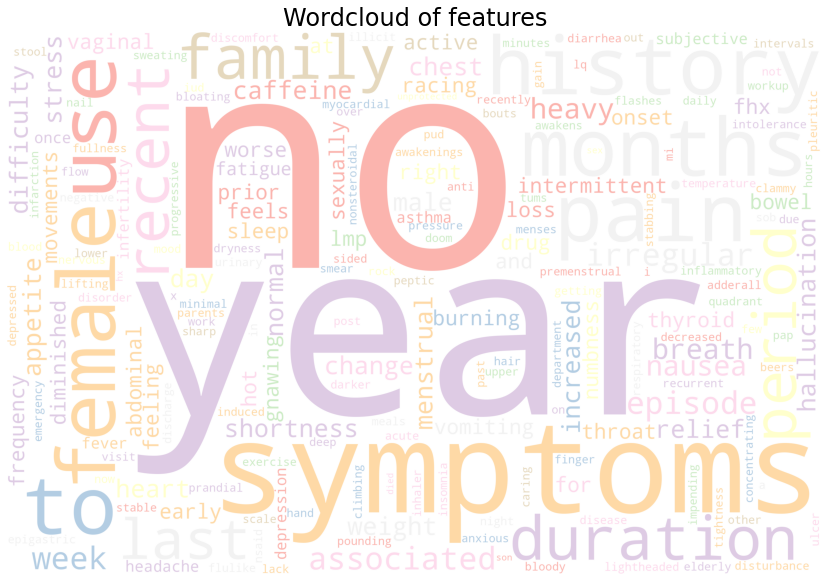

In [ ]:
# Import package
from wordcloud import WordCloud, STOPWORDS

# Generate word cloud
wordcloud = WordCloud(width=3000,
                      height=2000,
                      random_state=1,
                      background_color='white',
                      colormap='Pastel1',
                      collocations=False,
                      stopwords=['-', 'or', 'of', 'with', 'ago'])\
                      .generate(body)
# Plot
plt.rcParams["figure.figsize"] = (15, 10)
plt.imshow(wordcloud)
plt.title('Wordcloud of features', fontsize=24)
plt.axis('off')
plt.savefig('./wordcloud.png')

# Data_preprocess Functions

In [ ]:
BASE_URL = "content/nbme-score-clinical-patient-notes"

def process_feature_text(text):
    return text.replace("-OR-", ";-").replace("-", " ").replace("I-year", "1-year")

def prepare_datasets():
    features = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    df = pd.read_csv(f"{BASE_URL}/train.csv")

    df["annotation_list"] = [literal_eval(x) for x in df["annotation"]]
    df["location_list"] = [literal_eval(x) for x in df["location"]]

    df.loc[338, 'annotation_list'] = literal_eval('[["father heart attack"]]')
    df.loc[338, 'location_list'] = literal_eval('[["764 783"]]')

    df.loc[621, 'annotation_list'] = literal_eval('[["for the last 2-3 months"]]')
    df.loc[621, 'location_list'] = literal_eval('[["77 100"]]')

    df.loc[655, 'annotation_list'] = literal_eval('[["no heat intolerance"], ["no cold intolerance"]]')
    df.loc[655, 'location_list'] = literal_eval('[["285 292;301 312"], ["285 287;296 312"]]')

    df.loc[1262, 'annotation_list'] = literal_eval('[["mother thyroid problem"]]')
    df.loc[1262, 'location_list'] = literal_eval('[["551 557;565 580"]]')

    df.loc[1265, 'annotation_list'] = literal_eval('[[\'felt like he was going to "pass out"\']]')
    df.loc[1265, 'location_list'] = literal_eval('[["131 135;181 212"]]')

    df.loc[1396, 'annotation_list'] = literal_eval('[["stool , with no blood"]]')
    df.loc[1396, 'location_list'] = literal_eval('[["259 280"]]')

    df.loc[1591, 'annotation_list'] = literal_eval('[["diarrhoe non blooody"]]')
    df.loc[1591, 'location_list'] = literal_eval('[["176 184;201 212"]]')

    df.loc[1615, 'annotation_list'] = literal_eval('[["diarrhea for last 2-3 days"]]')
    df.loc[1615, 'location_list'] = literal_eval('[["249 257;271 288"]]')

    df.loc[1664, 'annotation_list'] = literal_eval('[["no vaginal discharge"]]')
    df.loc[1664, 'location_list'] = literal_eval('[["822 824;907 924"]]')

    df.loc[1714, 'annotation_list'] = literal_eval('[["started about 8-10 hours ago"]]')
    df.loc[1714, 'location_list'] = literal_eval('[["101 129"]]')

    df.loc[1929, 'annotation_list'] = literal_eval('[["no blood in the stool"]]')
    df.loc[1929, 'location_list'] = literal_eval('[["531 539;549 561"]]')

    df.loc[2134, 'annotation_list'] = literal_eval('[["last sexually active 9 months ago"]]')
    df.loc[2134, 'location_list'] = literal_eval('[["540 560;581 593"]]')

    df.loc[2191, 'annotation_list'] = literal_eval('[["right lower quadrant pain"]]')
    df.loc[2191, 'location_list'] = literal_eval('[["32 57"]]')

    df.loc[2553, 'annotation_list'] = literal_eval('[["diarrhoea no blood"]]')
    df.loc[2553, 'location_list'] = literal_eval('[["308 317;376 384"]]')

    df.loc[3124, 'annotation_list'] = literal_eval('[["sweating"]]')
    df.loc[3124, 'location_list'] = literal_eval('[["549 557"]]')

    df.loc[3858, 'annotation_list'] = literal_eval('[["previously as regular"], ["previously eveyr 28-29 days"], ["previously lasting 5 days"], ["previously regular flow"]]')
    df.loc[3858, 'location_list'] = literal_eval('[["102 123"], ["102 112;125 141"], ["102 112;143 157"], ["102 112;159 171"]]')

    df.loc[4373, 'annotation_list'] = literal_eval('[["for 2 months"]]')
    df.loc[4373, 'location_list'] = literal_eval('[["33 45"]]')

    df.loc[4763, 'annotation_list'] = literal_eval('[["35 year old"]]')
    df.loc[4763, 'location_list'] = literal_eval('[["5 16"]]')

    df.loc[4782, 'annotation_list'] = literal_eval('[["darker brown stools"]]')
    df.loc[4782, 'location_list'] = literal_eval('[["175 194"]]')

    df.loc[4908, 'annotation_list'] = literal_eval('[["uncle with peptic ulcer"]]')
    df.loc[4908, 'location_list'] = literal_eval('[["700 723"]]')

    df.loc[6016, 'annotation_list'] = literal_eval('[["difficulty falling asleep"]]')
    df.loc[6016, 'location_list'] = literal_eval('[["225 250"]]')

    df.loc[6192, 'annotation_list'] = literal_eval('[["helps to take care of aging mother and in-laws"]]')
    df.loc[6192, 'location_list'] = literal_eval('[["197 218;236 260"]]')

    df.loc[6380, 'annotation_list'] = literal_eval('[["No hair changes"], ["No skin changes"], ["No GI changes"], ["No palpitations"], ["No excessive sweating"]]')
    df.loc[6380, 'location_list'] = literal_eval('[["480 482;507 519"], ["480 482;499 503;512 519"], ["480 482;521 531"], ["480 482;533 545"], ["480 482;564 582"]]')

    df.loc[6562, 'annotation_list'] = literal_eval('[["stressed due to taking care of her mother"], ["stressed due to taking care of husbands parents"]]')
    df.loc[6562, 'location_list'] = literal_eval('[["290 320;327 337"], ["290 320;342 358"]]')

    df.loc[6862, 'annotation_list'] = literal_eval('[["stressor taking care of many sick family members"]]')
    df.loc[6862, 'location_list'] = literal_eval('[["288 296;324 363"]]')

    df.loc[7022, 'annotation_list'] = literal_eval('[["heart started racing and felt numbness for the 1st time in her finger tips"]]')
    df.loc[7022, 'location_list'] = literal_eval('[["108 182"]]')

    df.loc[7422, 'annotation_list'] = literal_eval('[["first started 5 yrs"]]')
    df.loc[7422, 'location_list'] = literal_eval('[["102 121"]]')

    df.loc[8876, 'annotation_list'] = literal_eval('[["No shortness of breath"]]')
    df.loc[8876, 'location_list'] = literal_eval('[["481 483;533 552"]]')

    df.loc[9027, 'annotation_list'] = literal_eval('[["recent URI"], ["nasal stuffines, rhinorrhea, for 3-4 days"]]')
    df.loc[9027, 'location_list'] = literal_eval('[["92 102"], ["123 164"]]')

    df.loc[9938, 'annotation_list'] = literal_eval('[["irregularity with her cycles"], ["heavier bleeding"], ["changes her pad every couple hours"]]')
    df.loc[9938, 'location_list'] = literal_eval('[["89 117"], ["122 138"], ["368 402"]]')

    df.loc[9973, 'annotation_list'] = literal_eval('[["gaining 10-15 lbs"]]')
    df.loc[9973, 'location_list'] = literal_eval('[["344 361"]]')

    df.loc[10513, 'annotation_list'] = literal_eval('[["weight gain"], ["gain of 10-16lbs"]]')
    df.loc[10513, 'location_list'] = literal_eval('[["600 611"], ["607 623"]]')

    df.loc[11551, 'annotation_list'] = literal_eval('[["seeing her son knows are not real"]]')
    df.loc[11551, 'location_list'] = literal_eval('[["386 400;443 461"]]')

    df.loc[11677, 'annotation_list'] = literal_eval('[["saw him once in the kitchen after he died"]]')
    df.loc[11677, 'location_list'] = literal_eval('[["160 201"]]')

    df.loc[12124, 'annotation_list'] = literal_eval('[["tried Ambien but it didnt work"]]')
    df.loc[12124, 'location_list'] = literal_eval('[["325 337;349 366"]]')

    df.loc[12279, 'annotation_list'] = literal_eval('[["heard what she described as a party later than evening these things did not actually happen"]]')
    df.loc[12279, 'location_list'] = literal_eval('[["405 459;488 524"]]')

    df.loc[12289, 'annotation_list'] = literal_eval('[["experienced seeing her son at the kitchen table these things did not actually happen"]]')
    df.loc[12289, 'location_list'] = literal_eval('[["353 400;488 524"]]')

    df.loc[13238, 'annotation_list'] = literal_eval('[["SCRACHY THROAT"], ["RUNNY NOSE"]]')
    df.loc[13238, 'location_list'] = literal_eval('[["293 307"], ["321 331"]]')

    df.loc[13297, 'annotation_list'] = literal_eval('[["without improvement when taking tylenol"], ["without improvement when taking ibuprofen"]]')
    df.loc[13297, 'location_list'] = literal_eval('[["182 221"], ["182 213;225 234"]]')

    df.loc[13299, 'annotation_list'] = literal_eval('[["yesterday"], ["yesterday"]]')
    df.loc[13299, 'location_list'] = literal_eval('[["79 88"], ["409 418"]]')

    df.loc[13845, 'annotation_list'] = literal_eval('[["headache global"], ["headache throughout her head"]]')
    df.loc[13845, 'location_list'] = literal_eval('[["86 94;230 236"], ["86 94;237 256"]]')

    df.loc[14083, 'annotation_list'] = literal_eval('[["headache generalized in her head"]]')
    df.loc[14083, 'location_list'] = literal_eval('[["56 64;156 179"]]')

    merged = df.merge(notes, how="left")
    merged = merged.merge(features, how="left")

    merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
    merged["feature_text"] = merged["feature_text"].apply(lambda x: x.lower())
    merged["pn_history"] = merged["pn_history"].apply(lambda x: x.lower())

    if hyperparameters['debug']:
        merged = merged.sample(n=1000,random_state=0).reset_index(drop=True)

    return merged

# Tokenizer Helper Functions

In [ ]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return


def tokenize_and_add_labels(tokenizer, data, config):
    out = tokenizer(
        data["feature_text"],
        data["pn_history"],
        truncation=config['truncation'],
        max_length=config['max_length'],
        padding=config['padding'],
        return_offsets_mapping=config['return_offsets_mapping']
    )
    labels = [0.0] * len(out["input_ids"])
    out["location_int"] = loc_list_to_ints(data["location_list"])
    out["sequence_ids"] = out.sequence_ids()

    for idx, (seq_id, offsets) in enumerate(zip(out["sequence_ids"],
                                                out["offset_mapping"])):
        if not seq_id or seq_id == 0:
            labels[idx] = -1
            continue

        token_start, token_end = offsets
        for feature_start, feature_end in out["location_int"]:
            if token_start >= feature_start and token_end <= feature_end:
                labels[idx] = 1.0
                break

    out["labels"] = labels

    return out

# Prediction and Score Helper Function

In [ ]:
def get_location_predictions(preds, offset_mapping, sequence_ids, test=False):
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        pred = 1 / (1 + np.exp(-pred))
        start_idx = None
        end_idx = None
        current_preds = []
        for pred, offset, seq_id in zip(pred, offsets, seq_ids):
            if seq_id is None or seq_id == 0:
                continue

            if pred > 0.5:
                if start_idx is None:
                    start_idx = offset[0]
                end_idx = offset[1]
            elif start_idx is not None:
                if test:
                    current_preds.append(f"{start_idx} {end_idx}")
                else:
                    current_preds.append((start_idx, end_idx))
                start_idx = None
        if test:
            all_predictions.append("; ".join(current_preds))
        else:
            all_predictions.append(current_preds)

    return all_predictions


def calculate_char_cv(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping, sequence_ids, labels):

        num_chars = max(list(chain(*offsets)))
        char_labels = np.zeros(num_chars)

        for o, s_id, label in zip(offsets, seq_ids, labels):
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]:o[1]] = 1

        char_preds = np.zeros(num_chars)

        for start_idx, end_idx in preds:
            char_preds[start_idx:end_idx] = 1

        all_labels.extend(char_labels)
        all_preds.extend(char_preds)

    results = precision_recall_fscore_support(all_labels, all_preds, average="binary", labels=np.unique(all_preds))

    accuracy = accuracy_score(all_labels, all_preds)

    return {
        "Accuracy": accuracy,
        "precision": results[0],
        "recall": results[1],
        "f1": results[2]
    }

# Data_Loader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        tokens = tokenize_and_add_labels(self.tokenizer, data, self.config)

        input_ids = np.array(tokens["input_ids"])
        attention_mask = np.array(tokens["attention_mask"])
        token_type_ids = np.array(tokens["token_type_ids"])

        labels = np.array(tokens["labels"])
        offset_mapping = np.array(tokens['offset_mapping'])
        sequence_ids = np.array(tokens['sequence_ids']).astype("float16")

        return input_ids, attention_mask, token_type_ids, labels, offset_mapping, sequence_ids

In [ ]:
hyperparameters = {
    "max_length": 416,
    "padding": "max_length",
    "return_offsets_mapping": True,
    "truncation": "only_second",
    "debug": False,

    "model_name": ("content/layoutlm/BiomedNLP-PubMedBERT"
                   "-base-uncased-abstract-fulltext"),
    "dropout": 0.5,
    "encoder_lr": 2e-5,
    "decoder_lr": 2e-5,
    "weight_decay": 0.001,
    "betas": (0.9, 0.999),
    "hidden_size":768,

    "seed": 1268,
    "batch_size": 8,
    "epochs": 3,

    "apex": True,
    "eps": 1e-6,

    "n_fold": 5,
    "trn_fold": [1, 2, 3, 4, 5]
}
if hyperparameters['debug']:
    hyperparameters['epochs'] = 2
    hyperparameters['trn_fold'] = [1,2]

# Models

In [ ]:
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = AutoModel.from_pretrained(config['model_name'])
        self.config = config
        self.dropout = nn.Dropout(p=config['dropout'])
#         self.fc1 = nn.Linear(768, 512)
#         self.fc2 = nn.Linear(512, 512)
#         self.fc3 = nn.Linear(512, 1)

#         self.lstm = nn.LSTM(input_size=768, hidden_size=384,
#                             num_layers=2, bidirectional=True, batch_first=True)
#         self.groupnorm = nn.GroupNorm(768, num_channels=config['max_length'])
        self.fc = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
#         logits = F.relu(self.fc1(outputs[0]))
#         logits = F.relu(self.fc2(self.dropout(logits)))
#         logits = self.fc3(self.dropout(logits)).squeeze(-1)

#         enc, _ = self.lstm(outputs[0])
#         logits = self.fc(self.dropout(enc)).squeeze(-1)

#         logits = self.groupnorm(self.dropout(outputs[0]))

        logits = F.relu(self.dropout(outputs[0]))
        logits = self.fc(logits).squeeze(-1)

        return logits

In [ ]:
# 实例化K折
from sklearn.model_selection import KFold
fold = KFold(n_splits=5, shuffle=True, random_state=1268)

In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['model_name'])
tokenizer.save_pretrained('./tokenizer/')

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.txt',
 './tokenizer/added_tokens.json',
 './tokenizer/tokenizer.json')

# Train

In [ ]:
# Optimizer
def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters

In [ ]:
def train_model(model, dataloader, optimizer, criterion):
    #,scheduler
    model.train()
    train_loss = []
    #scaler = torch.cuda.amp.GradScaler(enabled=hyperparameters['apex'])
    global_step = 0
    for step,batch in enumerate(tqdm(dataloader)):
        optimizer.zero_grad()

        input_ids = batch[0].to(DEVICE)

        attention_mask = batch[1].to(DEVICE)

        token_type_ids = batch[2].to(DEVICE)

        labels = batch[3].to(DEVICE)


        logits = model(input_ids, attention_mask, token_type_ids)


        loss = criterion(logits, labels)

        loss = torch.masked_select(loss, labels > -1.0).mean()
        train_loss.append(loss.item() * input_ids.size(0))
        loss.backward()
        #scaler.scale(loss).backward()
        # clip the the gradients to 1.0.
        # It helps in preventing the exploding gradient problem
        # it's also improve f1 accuracy slightly
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
#         if (step+1) % hyperparameters['gradient_accumulation_steps'] ==0:
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad()
#             global_step+=1
#             if hyperparameters['batch_scheduler']:
#                 scheduler.step()

    return sum(train_loss) / len(train_loss)

In [ ]:
def eval_model(model, dataloader, criterion):
        model.eval()
        valid_loss = []
        preds = []
        offsets = []
        seq_ids = []
        valid_labels = []

        for batch in tqdm(dataloader):
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)
            offset_mapping = batch[4]
            sequence_ids = batch[5]

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, labels)
            loss = torch.masked_select(loss, labels > -1.0).mean()
            valid_loss.append(loss.item() * input_ids.size(0))

            preds.append(logits.detach().cpu().numpy())
            offsets.append(offset_mapping.numpy())
            seq_ids.append(sequence_ids.numpy())
            valid_labels.append(labels.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        offsets = np.concatenate(offsets, axis=0)
        seq_ids = np.concatenate(seq_ids, axis=0)
        valid_labels = np.concatenate(valid_labels, axis=0)

        location_preds = get_location_predictions(preds,offsets,seq_ids, test=False)
        score = calculate_char_cv(location_preds, offsets, seq_ids, valid_labels)

        return sum(valid_loss)/len(valid_loss), score

In [ ]:
train_df = prepare_datasets()

第1折模型
训练集大小：11440
 测试集大小:2860
Epoch: 1/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.3663359366232286


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.1315223512051893
Valid score: {'Accuracy': 0.9935193244604353, 'precision': 0.8010706108051241, 'recall': 0.7478263381380167, 'f1': 0.7735333223777583}
Epoch: 2/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.1178015015705221


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.12413657480512175
Valid score: {'Accuracy': 0.99282205011483, 'precision': 0.7042408412949344, 'recall': 0.8878939310783096, 'f1': 0.7854751744052334}
Epoch: 3/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.08156475697111548


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.09996473767776574
Valid score: {'Accuracy': 0.9940639765243845, 'precision': 0.7706505847953217, 'recall': 0.8526820532077761, 'f1': 0.8095936810059927}


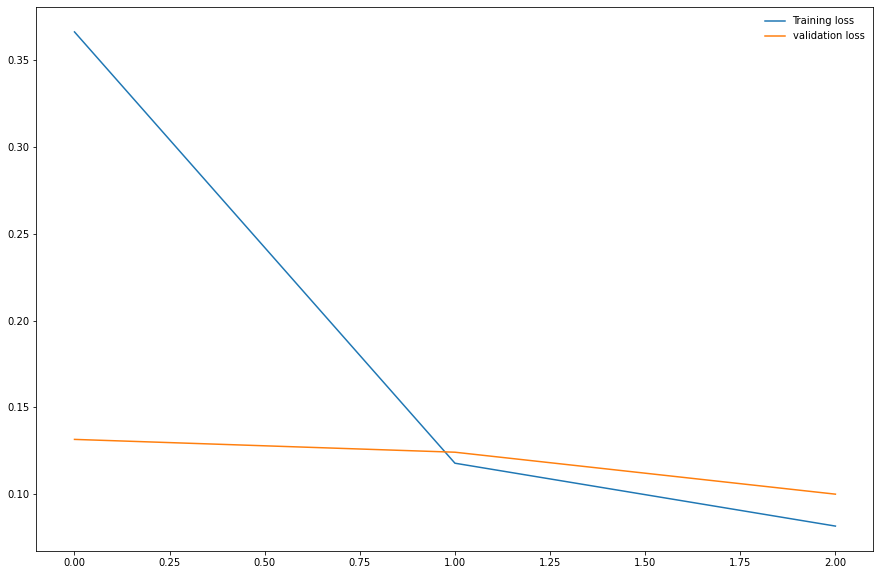

第2折模型
训练集大小：11440
 测试集大小:2860
Epoch: 1/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.2674760514522487


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.13144400860184288
Valid score: {'Accuracy': 0.993587527528994, 'precision': 0.7917309747120979, 'recall': 0.7703526150114073, 'f1': 0.7808955049107863}
Epoch: 2/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.11012603718124704


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.10971260359165452
Valid score: {'Accuracy': 0.9944421525927697, 'precision': 0.8102237886472392, 'recall': 0.8165882115112485, 'f1': 0.8133935506141589}
Epoch: 3/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.07779990269079791


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.11402654569269263
Valid score: {'Accuracy': 0.9943294877347381, 'precision': 0.7929013529057348, 'recall': 0.836110549571144, 'f1': 0.813932893830562}


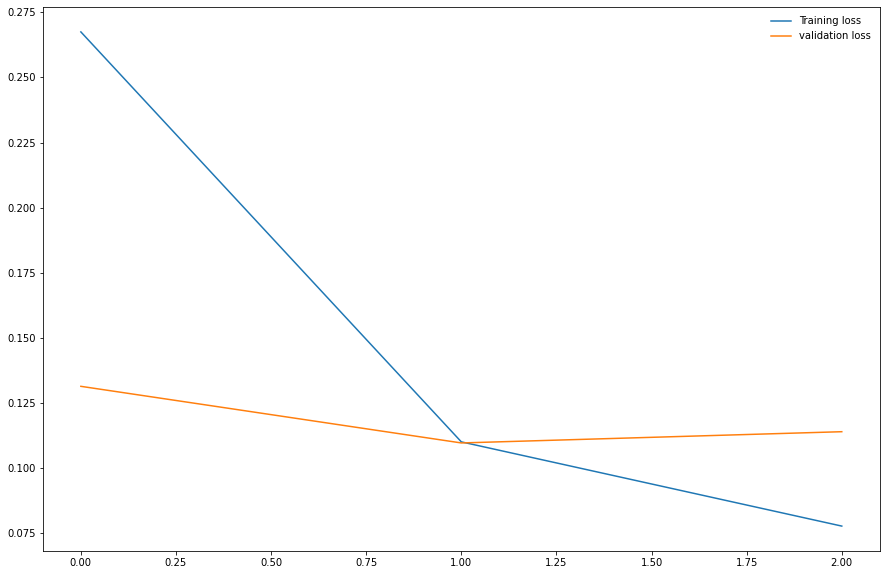

第3折模型
训练集大小：11440
 测试集大小:2860
Epoch: 1/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.29235007990509837


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.12423442556643254
Valid score: {'Accuracy': 0.993660520984603, 'precision': 0.7728269225293967, 'recall': 0.8000235786495329, 'f1': 0.786190117592539}
Epoch: 2/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.11208661268537551


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.10198394096382307
Valid score: {'Accuracy': 0.9944312717860551, 'precision': 0.7862762237762237, 'recall': 0.8483598101918712, 'f1': 0.8161390475920438}
Epoch: 3/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.07851674022766361


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.10935603971519198
Valid score: {'Accuracy': 0.9943917681238079, 'precision': 0.7771314741035856, 'recall': 0.8623596333519997, 'f1': 0.8175302812277344}


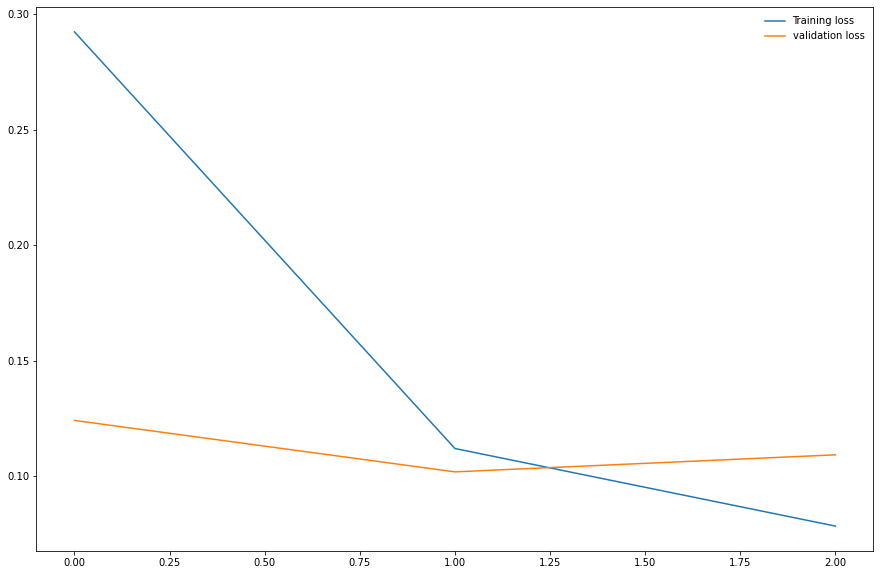

第4折模型
训练集大小：11440
 测试集大小:2860
Epoch: 1/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.2686884309385184


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.12379279434880756
Valid score: {'Accuracy': 0.9936213277246805, 'precision': 0.7582180044813497, 'recall': 0.8340002319647414, 'f1': 0.7943056763735278}
Epoch: 2/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.10871622956731256


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.11441680987595108
Valid score: {'Accuracy': 0.9941398597865326, 'precision': 0.7920480709833212, 'recall': 0.817907678032939, 'f1': 0.8047701920059342}
Epoch: 3/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.07872400378977634


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.11164372080984454
Valid score: {'Accuracy': 0.9943124183504686, 'precision': 0.7766904146767922, 'recall': 0.8629668290419856, 'f1': 0.8175587512189763}


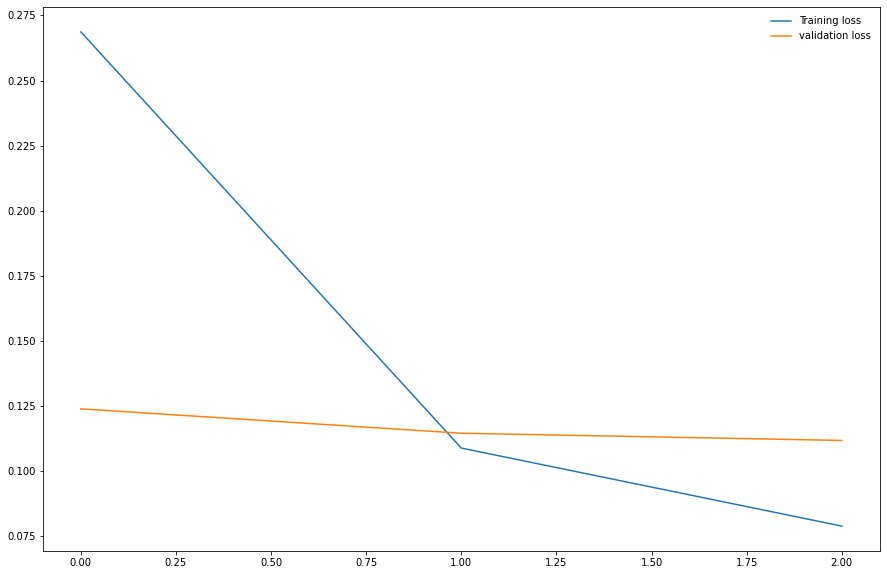

第5折模型
训练集大小：11440
 测试集大小:2860
Epoch: 1/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.2789395096491518


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.1306303475747587
Valid score: {'Accuracy': 0.992876300605737, 'precision': 0.717361302787745, 'recall': 0.841521208018132, 'f1': 0.7744967897488689}
Epoch: 2/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.1086421860141706


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.11778128317283762
Valid score: {'Accuracy': 0.9935404032883353, 'precision': 0.7363347271953327, 'recall': 0.8655991522679775, 'f1': 0.7957515897713436}
Epoch: 3/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.07725298483172757


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.10727056304644726
Valid score: {'Accuracy': 0.9941339022707861, 'precision': 0.7646812957157785, 'recall': 0.861625408412563, 'f1': 0.8102639336774944}


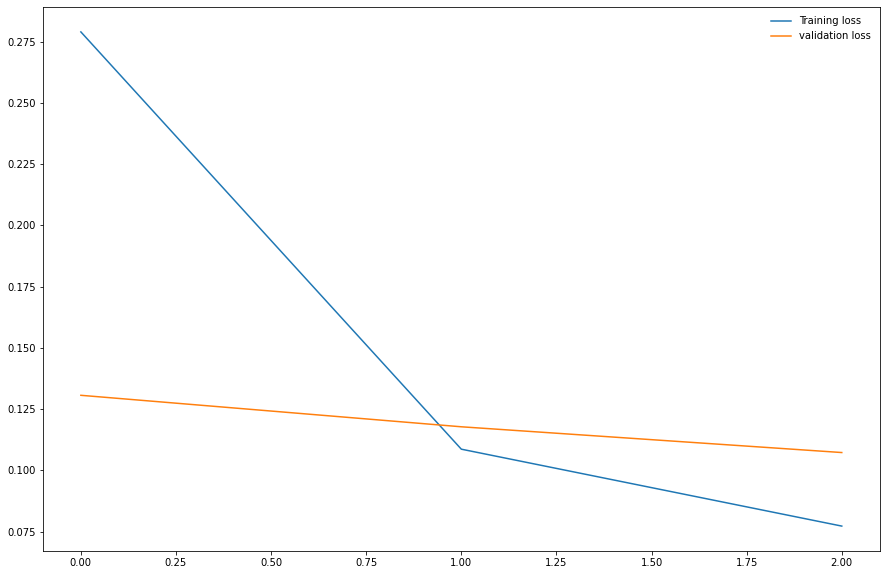

Performance of 5 fold cross validation
Average Training Loss: 0.220 	 Average Valid Loss: 0.122 	 Average Score: 0.79
Training completed in 157m 21s


<Figure size 1080x720 with 0 Axes>

In [ ]:
import time, gc
since = time.time()

from torch.utils.data import random_split,SubsetRandomSampler
from matplotlib import pyplot as plt

train_loss_data_avg, valid_loss_data_avg, score_data_avg_list= [], [], []
df_data = CustomDataset(train_df,tokenizer,hyperparameters)

fold_num = 0
for train_index,test_index in fold.split(train_df):
    if (fold_num+1) in hyperparameters['trn_fold']:
        train_sampler = SubsetRandomSampler(train_index)
        test_sampler = SubsetRandomSampler(test_index)
        print(f'{fold_num+1}')
        print(f'train：{len(train_index)}\n',f'test:{len(test_index)}')

        train_dataloader = DataLoader(df_data,
                                     batch_size=hyperparameters['batch_size'],
                                     shuffle=False,pin_memory=True,sampler=train_sampler)
        test_dataloader = DataLoader(df_data,
                                     batch_size=hyperparameters['batch_size'],
                                     shuffle=False,pin_memory=True,sampler=test_sampler)

        train_loss_data, valid_loss_data, score_data_list = [], [], []
        valid_loss_min = np.Inf
        best_loss = np.inf

        DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

        model = CustomModel(hyperparameters).to(DEVICE)
        criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
        optimizer_parameters = get_optimizer_params(model,
                                            encoder_lr=hyperparameters['encoder_lr'],
                                            decoder_lr=hyperparameters['decoder_lr'],
                                            weight_decay=hyperparameters['weight_decay'])
        optimizer = optim.AdamW(optimizer_parameters, lr=hyperparameters['encoder_lr'],eps=hyperparameters['eps'],betas=hyperparameters['betas'])

        for i in range(hyperparameters['epochs']):
            print("Epoch: {}/{}".format(i + 1, hyperparameters['epochs']))
            # first train model
            train_loss = train_model(model, train_dataloader, optimizer, criterion)
#             train_loss = train_loss/len(train_dataloader.sampler)
            train_loss_data.append(train_loss)
            print(f"Train loss: {train_loss}")

            #evaluate model
            valid_loss, score = eval_model(model, test_dataloader, criterion)
#             valid_loss = valid_loss/len(test_dataloader.sampler)
            valid_loss_data.append(valid_loss)
            score_data_list.append(score['f1'])
            print(f"Valid loss: {valid_loss}")
            print(f"Valid score: {score}")

            if valid_loss < best_loss:
                best_loss = valid_loss
                torch.save(model.state_dict(), f"nbme_pubmed_bert_fold{fold_num+1}.pth")

            train_loss_data_avg.append(np.mean(train_loss_data))
            valid_loss_data_avg.append(np.mean(valid_loss_data))
            score_data_avg_list.append(np.mean(score_data_list))

        plt.plot(train_loss_data, label="Training loss")
        plt.plot(valid_loss_data, label="validation loss")
        plt.legend(frameon=False)
        plt.show()
        plt.clf()

        torch.cuda.empty_cache()
        gc.collect()
        fold_num+=1
    else:
        fold_num+=1
        train_loss_data, valid_loss_data, score_data_list = [], [], []
        valid_loss_min = np.Inf
        best_loss = np.inf

print('Performance of {} fold cross validation'.format(hyperparameters['n_fold']))
print("Average Training Loss: {:.3f} \t Average Valid Loss: {:.3f} \t Average Score: {:.2f}"
      .format(np.mean(train_loss_data_avg),np.mean(valid_loss_data_avg),np.mean(score_data_avg_list)))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [ ]:
# from matplotlib import pyplot as plt

# plt.plot(train_loss_data, label="Training loss")
# plt.plot(valid_loss_data, label="validation loss")
# plt.legend(frameon=False)

In [ ]:
import pandas as pd

score_df = pd.DataFrame.from_dict(score_data_list)
score_df.head()

,0
0,0.774497
1,0.795752
2,0.810264


# Prediction

In [ ]:
def create_test_df():
    feats = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    test = pd.read_csv(f"{BASE_URL}/test.csv")

    merged = test.merge(notes, how="left")
    merged = merged.merge(feats, how="left")

    def process_feature_text(text):
        return text.replace("-OR-", ";-").replace("-", " ").replace("I-year", "1-year")

    merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
    return merged


class SubmissionDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data.loc[idx]
        tokenized = self.tokenizer(
            example["feature_text"],
            example["pn_history"],
            truncation = self.config['truncation'],
            max_length = self.config['max_length'],
            padding = self.config['padding'],
            return_offsets_mapping = self.config['return_offsets_mapping']
        )
        tokenized["sequence_ids"] = tokenized.sequence_ids()

        input_ids = np.array(tokenized["input_ids"])
        attention_mask = np.array(tokenized["attention_mask"])
        token_type_ids = np.array(tokenized["token_type_ids"])
        offset_mapping = np.array(tokenized["offset_mapping"])
        sequence_ids = np.array(tokenized["sequence_ids"])\
                        .astype("float16")

        return input_ids, attention_mask, token_type_ids, offset_mapping, sequence_ids


test_df = create_test_df()

submission_data = SubmissionDataset(test_df, tokenizer, hyperparameters)
submission_dataloader = DataLoader(submission_data,
                                   batch_size=hyperparameters['batch_size'],
                                   pin_memory=True,
                                   shuffle=False)

In [ ]:
preds = []
offsets = []
seq_ids = []
logits_container = []
for batch in tqdm(submission_dataloader):
    input_ids = batch[0].to(DEVICE)
    attention_mask = batch[1].to(DEVICE)
    token_type_ids = batch[2].to(DEVICE)
    offset_mapping = batch[3]
    sequence_ids = batch[4]

    for fold in hyperparameters['trn_fold']:
        model.load_state_dict(torch.load(f"nbme_pubmed_bert_fold{fold}.pth"))
        model.eval()
        logits = model(input_ids, attention_mask, token_type_ids).detach().cpu().numpy()
        logits_container.append(logits)

    print(logits_container)
    preds.append(np.mean(logits_container,axis=0))
    offsets.append(offset_mapping.numpy())
    seq_ids.append(sequence_ids.numpy())

preds = np.concatenate(preds, axis=0)
offsets = np.concatenate(offsets, axis=0)
seq_ids = np.concatenate(seq_ids, axis=0)


In [ ]:
location_preds = get_location_predictions(preds, offsets, seq_ids, test=True)
test_df["location"] = location_preds
test_df[["id", "location"]].to_csv("submission.csv", index = False)
pd.read_csv(f"{BASE_URL}/test.csv")